In [1]:
import torch
import torch.nn as nn
import random
import math
import numpy as np
import cmath
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch.nn.utils as utils

In [2]:
np_kernel_split = np.load('kernal_4x5x4x5.npy')
kernel_split = torch.from_numpy(np_kernel_split)
TotalSampleSize = kernel_split.size(0)
print(TotalSampleSize)
NumberOfUsers = kernel_split.size(1)
TimeLength = kernel_split.size(2)
kernel_split = kernel_split.reshape((TotalSampleSize, NumberOfUsers * TimeLength * NumberOfUsers * TimeLength, 2))
kernel = torch.complex(kernel_split[:,:,0], kernel_split[:,:,1])
kernel = kernel.reshape((TotalSampleSize, NumberOfUsers * TimeLength, NumberOfUsers * TimeLength))    
kernel_split = kernel_split.reshape((TotalSampleSize, NumberOfUsers * TimeLength * NumberOfUsers * TimeLength* 2))

penality = 0.01
NumberOfEpochs = 500
BatchSize = 16
NumberOfEigenFun = 10


TrainSampleSize = int((TotalSampleSize/5)*4)
TestSampleSize = int((TotalSampleSize/5)*1)

NumberOfTrainBatches = int((TrainSampleSize/BatchSize))
NumberOfTestBatches = int((TestSampleSize/BatchSize))

EigneVectorSize = NumberOfUsers * TimeLength
VmatrixLocation = NumberOfEigenFun + NumberOfEigenFun*EigneVectorSize
NNOutputPerEigenFn = 2 * NumberOfUsers * TimeLength + 1
NumberOfOutputs = NumberOfEigenFun * NNOutputPerEigenFn

SizeOfInputLayer = NumberOfUsers * TimeLength * NumberOfUsers * TimeLength * 2
SizeOfHiddenLayer1 =  SizeOfInputLayer 
SizeOfOutputLayer = 2 * NumberOfOutputs
SizeOfHiddenLayer2 =  (int)((SizeOfInputLayer + SizeOfOutputLayer)/2)
#SizeOfHiddenLayer3 =  SizeOfInputLayer * 2
#SizeOfHiddenLayer4 =  SizeOfInputLayer   


1280


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(0)

In [5]:
class NNetwork(nn.Module):
    def __init__(self):
        super(NNetwork, self).__init__()
        self.fc1 = nn.Linear(SizeOfInputLayer, SizeOfHiddenLayer1)
        self.relu1 = nn.LeakyReLU(0.1)
        self.fc2 = nn.Linear(SizeOfHiddenLayer1, SizeOfHiddenLayer2)
        self.relu2 = nn.LeakyReLU(0.1)
        self.fc3 = nn.Linear(SizeOfHiddenLayer2, SizeOfOutputLayer)
#        self.relu3 = nn.LeakyReLU(0.2)
#        self.fc4 = nn.Linear(SizeOfHiddenLayer3, SizeOfHiddenLayer4)
#        self.relu4 = nn.LeakyReLU(0.2)
#        self.fc5 = nn.Linear(SizeOfHiddenLayer4, SizeOfOutputLayer)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
#        x = self.relu3(x)
#        x = self.fc4(x)
#        x = self.relu4(x)
#        x = self.fc5(x)
        return x
#model = NNetwork()
model = NNetwork().to(device)
print(model)

NNetwork(
  (fc1): Linear(in_features=800, out_features=800, bias=True)
  (relu1): LeakyReLU(negative_slope=0.1)
  (fc2): Linear(in_features=800, out_features=810, bias=True)
  (relu2): LeakyReLU(negative_slope=0.1)
  (fc3): Linear(in_features=810, out_features=820, bias=True)
)


In [6]:
def orthogonalityCheck(matrix, batch_Size):
    sumVal = 0
    for i in range(batch_Size):
        for j in range(NumberOfEigenFun):
            for k in range(NumberOfEigenFun-(j+1)):
                sumVal = sumVal + torch.abs(torch.sum(matrix[i,:,j] * matrix[i,:,(k+j+1)]))
    return sumVal/batch_Size

In [7]:
#loss = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, nnOutput, train_kernals_2d, batch_Size):
        nnOut_matrix_complex = torch.complex(nnOutput[:,0:NumberOfOutputs], nnOutput[:,NumberOfOutputs:SizeOfOutputLayer])

        diagonalMatrix = torch.diag_embed(nnOut_matrix_complex[:,0:NumberOfEigenFun])

        UVectorMatrixTmp = nnOut_matrix_complex[:, NumberOfEigenFun:VmatrixLocation]
        UVectorMatrix = UVectorMatrixTmp.view(batch_Size, EigneVectorSize, NumberOfEigenFun)
        
        VVectorMatrixTmp = nnOut_matrix_complex[:, VmatrixLocation:NumberOfOutputs]
        VVectorMatrix = VVectorMatrixTmp.view(batch_Size, EigneVectorSize, NumberOfEigenFun)
        transposedV = torch.transpose(VVectorMatrix, 1, 2)

        obj1 = orthogonalityCheck(UVectorMatrix, batch_Size)
        obj2 = orthogonalityCheck(VVectorMatrix, batch_Size)

        kernels_pred = UVectorMatrix @ diagonalMatrix @ transposedV
        
        #lossTmp = torch.pow(torch.norm((train_kernals_2d - kernels_pred),p=2),2) + penality*(obj1 + obj2)

        lossTmp = torch.pow(torch.norm((train_kernals_2d - kernels_pred),p=2),2)/torch.pow(torch.norm(train_kernals_2d,p=2),2) + penality*(obj1 + obj2)
        return lossTmp , obj1, obj2

custom_loss = CustomLoss()

In [8]:
train_loss_train = torch.zeros((NumberOfEpochs,1))
test_avg_loss_train = torch.zeros((NumberOfEpochs,1))
test_loss_train = torch.zeros((NumberOfEpochs,1))
train_obj1_train = torch.zeros((NumberOfEpochs,1))
test_avg_obj1_train = torch.zeros((NumberOfEpochs,1))
test_obj1_train = torch.zeros((NumberOfEpochs,1))
train_obj2_train = torch.zeros((NumberOfEpochs,1))
test_avg_obj2_train = torch.zeros((NumberOfEpochs,1))
test_obj2_train = torch.zeros((NumberOfEpochs,1))

In [9]:
def trainNN(train_kernel_split, train_kernel, test_kernel_split, test_kernel):
    lr = 0.00001
    train_kernel_split = train_kernel_split.to(device)
    train_kernel = train_kernel.to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    testlossPerEpoch = 0
    testobj1PerEpoch = 0
    testobj2PerEpoch = 0
    testlossPer1 = 0
    testobj1Per1 = 0
    testobj2Per1 = 0    
    for t in range(NumberOfEpochs):
        print(f'Epoch {t+1}')
        model.train()
        trainlossPerEpoch = 0
        trainobj1PerEpoch = 0
        trainobj2PerEpoch = 0
        for b in range(NumberOfTrainBatches):
            nnOut = model(train_kernel_split[(b*BatchSize):(b+1)*BatchSize,:])
            loss , obj_1, obj_2 = custom_loss(nnOut, train_kernel[(b*BatchSize):(b+1)*BatchSize, :, :], BatchSize)
            trainlossPerEpoch = trainlossPerEpoch + loss
            trainobj1PerEpoch = trainobj1PerEpoch + obj_1
            trainobj2PerEpoch = trainobj2PerEpoch + obj_2
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(trainlossPerEpoch/NumberOfTrainBatches)
        print('{:.12f}'.format(trainobj1PerEpoch/NumberOfTrainBatches))
        print('{:.12f}'.format(trainobj2PerEpoch/NumberOfTrainBatches))
        
        print('####################################')
        testlossPerEpoch = 0
        testobj1PerEpoch = 0
        testobj2PerEpoch = 0
        model.eval()
        with torch.no_grad():
            for v in range(NumberOfTestBatches):
                nnOut = model(test_kernel_split[(v*BatchSize):(v+1)*BatchSize,:])
                loss , obj_1, obj_2 = custom_loss(nnOut, test_kernel[(v*BatchSize):(v+1)*BatchSize, :, :], BatchSize)
                testlossPerEpoch = testlossPerEpoch + loss
                testobj1PerEpoch = testobj1PerEpoch + obj_1
                testobj2PerEpoch = testobj2PerEpoch + obj_2            
            print(testlossPerEpoch/NumberOfTestBatches)
            #print('{:.12f}'.format(testobj1PerEpoch/NumberOfTestBatches))
            #print('{:.12f}'.format(testobj2PerEpoch/NumberOfTestBatches))        
                
            print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
            nnOut = model(test_kernel_split[0:1,:])
            testlossPer1 , testobj1Per1, testobj2Per1 = custom_loss(nnOut, test_kernel[0:1, :, :], 1)
            print(testlossPer1)
            #print('{:.12f}'.format(testobj1Per1))
            #print('{:.12f}'.format(testobj2Per1))  
    
        train_loss_train[t] = trainlossPerEpoch/NumberOfTrainBatches
        test_avg_loss_train[t] = testlossPerEpoch/NumberOfTestBatches
        test_loss_train[t] = testlossPer1
        train_obj1_train[t] = trainobj1PerEpoch/NumberOfTrainBatches
        test_avg_obj1_train[t] = testobj1PerEpoch/NumberOfTestBatches
        test_obj1_train[t] = testobj1Per1
        train_obj2_train[t] = trainobj2PerEpoch/NumberOfTrainBatches
        test_avg_obj2_train[t] = testobj2PerEpoch/NumberOfTestBatches
        test_obj2_train[t] = testobj2Per1  

        
        

In [10]:
train_kernel_split = kernel_split[0:TrainSampleSize,:]
train_kernel_2d = kernel[0:TrainSampleSize,:,:]
test_kernel_split = kernel_split[TrainSampleSize:TotalSampleSize,:]
test_kernel_2d = kernel[TrainSampleSize:TotalSampleSize,:,:]
#trainNN( test_kernel_split, test_kernel_2d)


In [ ]:
trainNN( train_kernel_split, train_kernel_2d,test_kernel_split, test_kernel_2d)

Epoch 1
tensor(1.0174, grad_fn=<DivBackward0>)
0.880348801613
0.858854711056
####################################
tensor(1.0134)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0158)
Epoch 2
tensor(1.0113, grad_fn=<DivBackward0>)
0.568103194237
0.561513125896
####################################
tensor(1.0100)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0118)
Epoch 3
tensor(1.0086, grad_fn=<DivBackward0>)
0.434309124947
0.429563701153
####################################
tensor(1.0082)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0098)
Epoch 4
tensor(1.0070, grad_fn=<DivBackward0>)
0.354103028774
0.350117027760
####################################
tensor(1.0070)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0085)
Epoch 5
tensor(1.0059, grad_fn=<DivBackward0>)
0.298648208380
0.295198559761
####################################
tensor(1.0061)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0076)
Epoch 6
tensor(1.0051, grad_fn=<DivBackward0>)
0.257224261761
0.25424370169

tensor(1.0004)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0006)
Epoch 46
tensor(1.0002, grad_fn=<DivBackward0>)
0.010433748364
0.010370894335
####################################
tensor(1.0004)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0005)
Epoch 47
tensor(1.0002, grad_fn=<DivBackward0>)
0.010205994360
0.010144008324
####################################
tensor(1.0004)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0005)
Epoch 48
tensor(1.0002, grad_fn=<DivBackward0>)
0.009992142208
0.009931860492
####################################
tensor(1.0004)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0005)
Epoch 49
tensor(1.0002, grad_fn=<DivBackward0>)
0.009790597484
0.009731754661
####################################
tensor(1.0004)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0005)
Epoch 50
tensor(1.0002, grad_fn=<DivBackward0>)
0.009599422105
0.009541469626
####################################
tensor(1.0004)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0005)

tensor(1.0001, grad_fn=<DivBackward0>)
0.004787760321
0.004753737710
####################################
tensor(1.0003)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0003)
Epoch 91
tensor(1.0001, grad_fn=<DivBackward0>)
0.004695515614
0.004663390573
####################################
tensor(1.0003)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0003)
Epoch 92
tensor(1.0001, grad_fn=<DivBackward0>)
0.004605476744
0.004572717473
####################################
tensor(1.0003)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0003)
Epoch 93
tensor(1.0001, grad_fn=<DivBackward0>)
0.004515499342
0.004482780118
####################################
tensor(1.0002)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0003)
Epoch 94
tensor(1.0001, grad_fn=<DivBackward0>)
0.004426862579
0.004395034164
####################################
tensor(1.0002)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0003)
Epoch 95
tensor(1.0001, grad_fn=<DivBackward0>)
0.004338806495
0.004308928736
#

tensor(1.0000, grad_fn=<DivBackward0>)
0.001914976863
0.001901644748
####################################
tensor(1.0002)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0002)
Epoch 135
tensor(1.0000, grad_fn=<DivBackward0>)
0.001878776355
0.001864395337
####################################
tensor(1.0002)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0002)
Epoch 136
tensor(1.0000, grad_fn=<DivBackward0>)
0.001843929640
0.001827816828
####################################
tensor(1.0002)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0002)
Epoch 137
tensor(1.0000, grad_fn=<DivBackward0>)
0.001805626089
0.001790943556
####################################
tensor(1.0002)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0002)
Epoch 138
tensor(1.0000, grad_fn=<DivBackward0>)
0.001769405440
0.001756569487
####################################
tensor(1.0002)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0002)
Epoch 139
tensor(1.0000, grad_fn=<DivBackward0>)
0.001737015904
0.001721958

tensor(1.0000, grad_fn=<DivBackward0>)
0.001028486877
0.001024708385
####################################
tensor(1.0001)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0002)
Epoch 179
tensor(1.0000, grad_fn=<DivBackward0>)
0.001025458565
0.001017786912
####################################
tensor(1.0001)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0002)
Epoch 180
tensor(1.0000, grad_fn=<DivBackward0>)
0.001013621571
0.001006800565
####################################
tensor(1.0001)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0002)
Epoch 181
tensor(1.0000, grad_fn=<DivBackward0>)
0.001005074126
0.001005150494
####################################
tensor(1.0001)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0002)
Epoch 182
tensor(1.0000, grad_fn=<DivBackward0>)
0.001001491793
0.000996436574
####################################
tensor(1.0001)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0002)
Epoch 183
tensor(1.0000, grad_fn=<DivBackward0>)
0.000997877447
0.000998413

tensor(1.0000, grad_fn=<DivBackward0>)
0.000891038566
0.000902214728
####################################
tensor(1.0001)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0001)
Epoch 223
tensor(1.0000, grad_fn=<DivBackward0>)
0.000896630809
0.000906483270
####################################
tensor(1.0001)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0001)
Epoch 224
tensor(1.0000, grad_fn=<DivBackward0>)
0.000906864763
0.000916818622
####################################
tensor(1.0001)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0001)
Epoch 225
tensor(1.0000, grad_fn=<DivBackward0>)
0.000913784432
0.000925554021
####################################
tensor(1.0001)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0001)
Epoch 226
tensor(1.0000, grad_fn=<DivBackward0>)
0.000934480166
0.000939575315
####################################
tensor(1.0001)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(1.0001)
Epoch 227
tensor(1.0000, grad_fn=<DivBackward0>)
0.000944010448
0.000954902

tensor(0.9143, grad_fn=<DivBackward0>)
0.043528564274
0.297526896000
####################################
tensor(0.9336)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.9073)
Epoch 267
tensor(0.9095, grad_fn=<DivBackward0>)
0.043592561036
0.317716330290
####################################
tensor(0.9300)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.9027)
Epoch 268
tensor(0.9041, grad_fn=<DivBackward0>)
0.043686877936
0.339049071074
####################################
tensor(0.9261)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.8975)
Epoch 269
tensor(0.8982, grad_fn=<DivBackward0>)
0.043735936284
0.361324638128
####################################
tensor(0.9218)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.8918)
Epoch 270
tensor(0.8918, grad_fn=<DivBackward0>)
0.043705854565
0.384402334690
####################################
tensor(0.9173)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.8857)
Epoch 271
tensor(0.8850, grad_fn=<DivBackward0>)
0.043584328145
0.407124012

tensor(0.6712, grad_fn=<DivBackward0>)
0.044510051608
0.817895114422
####################################
tensor(0.7513)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.7439)
Epoch 311
tensor(0.6683, grad_fn=<DivBackward0>)
0.044365216047
0.818633675575
####################################
tensor(0.7488)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.7417)
Epoch 312
tensor(0.6655, grad_fn=<DivBackward0>)
0.044208943844
0.819432795048
####################################
tensor(0.7464)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.7396)
Epoch 313
tensor(0.6627, grad_fn=<DivBackward0>)
0.044048503041
0.820245504379
####################################
tensor(0.7440)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.7375)
Epoch 314
tensor(0.6600, grad_fn=<DivBackward0>)
0.043888028711
0.820903241634
####################################
tensor(0.7416)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.7354)
Epoch 315
tensor(0.6573, grad_fn=<DivBackward0>)
0.043729431927
0.821346640

tensor(0.5588, grad_fn=<DivBackward0>)
0.043984670192
0.896246254444
####################################
tensor(0.6592)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.6702)
Epoch 355
tensor(0.5561, grad_fn=<DivBackward0>)
0.044034481049
0.898633360863
####################################
tensor(0.6572)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.6689)
Epoch 356
tensor(0.5535, grad_fn=<DivBackward0>)
0.044080872089
0.900735914707
####################################
tensor(0.6551)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.6675)
Epoch 357
tensor(0.5509, grad_fn=<DivBackward0>)
0.044121541083
0.903152883053
####################################
tensor(0.6530)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.6661)
Epoch 358
tensor(0.5483, grad_fn=<DivBackward0>)
0.044158600271
0.905124962330
####################################
tensor(0.6509)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.6646)
Epoch 359
tensor(0.5458, grad_fn=<DivBackward0>)
0.044191874564
0.907017827

tensor(0.4762, grad_fn=<DivBackward0>)
0.043321225792
0.865296959877
####################################
tensor(0.5903)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.5972)
Epoch 399
tensor(0.4751, grad_fn=<DivBackward0>)
0.043299414217
0.862015247345
####################################
tensor(0.5892)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.5955)
Epoch 400
tensor(0.4740, grad_fn=<DivBackward0>)
0.043279159814
0.858016431332
####################################
tensor(0.5880)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.5939)
Epoch 401
tensor(0.4729, grad_fn=<DivBackward0>)
0.043257825077
0.854380249977
####################################
tensor(0.5869)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.5922)
Epoch 402
tensor(0.4719, grad_fn=<DivBackward0>)
0.043233070523
0.851349830627
####################################
tensor(0.5858)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.5904)
Epoch 403
tensor(0.4709, grad_fn=<DivBackward0>)
0.043210953474
0.847903847

tensor(0.4439, grad_fn=<DivBackward0>)
0.043643504381
0.706231653690
####################################
tensor(0.5550)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.5460)
Epoch 443
tensor(0.4434, grad_fn=<DivBackward0>)
0.043672271073
0.703457236290
####################################
tensor(0.5543)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.5454)
Epoch 444
tensor(0.4430, grad_fn=<DivBackward0>)
0.043701380491
0.700639247894
####################################
tensor(0.5538)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.5453)
Epoch 445
tensor(0.4426, grad_fn=<DivBackward0>)
0.043732389808
0.696520268917
####################################
tensor(0.5533)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.5451)
Epoch 446
tensor(0.4421, grad_fn=<DivBackward0>)
0.043764974922
0.693069994450
####################################
tensor(0.5529)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.5451)
Epoch 447
tensor(0.4417, grad_fn=<DivBackward0>)
0.043799914420
0.689061760

tensor(0.4332, grad_fn=<DivBackward0>)
0.046436358243
0.593743860722
####################################
tensor(0.5497)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.5226)
Epoch 487
tensor(0.4329, grad_fn=<DivBackward0>)
0.046522878110
0.591962277889
####################################
tensor(0.5487)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.5217)
Epoch 488
tensor(0.4326, grad_fn=<DivBackward0>)
0.046608135104
0.589997172356
####################################
tensor(0.5475)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.5208)
Epoch 489
tensor(0.4323, grad_fn=<DivBackward0>)
0.046690750867
0.587232053280
####################################
tensor(0.5464)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.5201)
Epoch 490
tensor(0.4320, grad_fn=<DivBackward0>)
0.046772241592
0.583963155746
####################################
tensor(0.5454)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.5192)
Epoch 491
tensor(0.4317, grad_fn=<DivBackward0>)
0.046852909029
0.580999016

tensor(0.4169, grad_fn=<DivBackward0>)
0.048488628119
0.500869512558
####################################
tensor(0.5238)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4987)
Epoch 531
tensor(0.4166, grad_fn=<DivBackward0>)
0.048507317901
0.500647962093
####################################
tensor(0.5234)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4987)
Epoch 532
tensor(0.4163, grad_fn=<DivBackward0>)
0.048521827906
0.499760419130
####################################
tensor(0.5232)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4988)
Epoch 533
tensor(0.4160, grad_fn=<DivBackward0>)
0.048535078764
0.498416155577
####################################
tensor(0.5232)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4990)
Epoch 534
tensor(0.4157, grad_fn=<DivBackward0>)
0.048548135906
0.497441500425
####################################
tensor(0.5232)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4991)
Epoch 535
tensor(0.4154, grad_fn=<DivBackward0>)
0.048564575613
0.495313704

tensor(0.4075, grad_fn=<DivBackward0>)
0.049525260925
0.436282962561
####################################
tensor(0.5179)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4800)
Epoch 575
tensor(0.4074, grad_fn=<DivBackward0>)
0.049563586712
0.433828473091
####################################
tensor(0.5176)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4787)
Epoch 576
tensor(0.4072, grad_fn=<DivBackward0>)
0.049603056163
0.431480318308
####################################
tensor(0.5175)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4777)
Epoch 577
tensor(0.4071, grad_fn=<DivBackward0>)
0.049649711698
0.430123806000
####################################
tensor(0.5174)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4767)
Epoch 578
tensor(0.4070, grad_fn=<DivBackward0>)
0.049695324153
0.427436441183
####################################
tensor(0.5171)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4758)
Epoch 579
tensor(0.4069, grad_fn=<DivBackward0>)
0.049748636782
0.425822019

tensor(0.4055, grad_fn=<DivBackward0>)
0.052954863757
0.402633875608
####################################
tensor(0.5101)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4608)
Epoch 619
tensor(0.4054, grad_fn=<DivBackward0>)
0.053045306355
0.401574999094
####################################
tensor(0.5102)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4608)
Epoch 620
tensor(0.4052, grad_fn=<DivBackward0>)
0.053131278604
0.402293533087
####################################
tensor(0.5103)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4608)
Epoch 621
tensor(0.4051, grad_fn=<DivBackward0>)
0.053216658533
0.401554703712
####################################
tensor(0.5104)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4607)
Epoch 622
tensor(0.4050, grad_fn=<DivBackward0>)
0.053303346038
0.401421993971
####################################
tensor(0.5105)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4607)
Epoch 623
tensor(0.4048, grad_fn=<DivBackward0>)
0.053387943655
0.401458293

tensor(0.3980, grad_fn=<DivBackward0>)
0.055903613567
0.335913509130
####################################
tensor(0.5034)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4612)
Epoch 663
tensor(0.3979, grad_fn=<DivBackward0>)
0.055950690061
0.334890455008
####################################
tensor(0.5034)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4615)
Epoch 664
tensor(0.3977, grad_fn=<DivBackward0>)
0.055999144912
0.334956288338
####################################
tensor(0.5033)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4619)
Epoch 665
tensor(0.3976, grad_fn=<DivBackward0>)
0.056050390005
0.334911555052
####################################
tensor(0.5035)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4624)
Epoch 666
tensor(0.3975, grad_fn=<DivBackward0>)
0.056103784591
0.333395600319
####################################
tensor(0.5037)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4628)
Epoch 667
tensor(0.3974, grad_fn=<DivBackward0>)
0.056149140000
0.331736832

tensor(0.3963, grad_fn=<DivBackward0>)
0.059067733586
0.310072511435
####################################
tensor(0.5025)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4632)
Epoch 707
tensor(0.3963, grad_fn=<DivBackward0>)
0.059160709381
0.310332953930
####################################
tensor(0.5017)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4626)
Epoch 708
tensor(0.3962, grad_fn=<DivBackward0>)
0.059249978513
0.309689432383
####################################
tensor(0.5010)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4618)
Epoch 709
tensor(0.3962, grad_fn=<DivBackward0>)
0.059342633933
0.309788018465
####################################
tensor(0.5004)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4608)
Epoch 710
tensor(0.3961, grad_fn=<DivBackward0>)
0.059430357069
0.310928761959
####################################
tensor(0.4998)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4601)
Epoch 711
tensor(0.3961, grad_fn=<DivBackward0>)
0.059516046196
0.311351478

tensor(0.3901, grad_fn=<DivBackward0>)
0.061442472041
0.275802701712
####################################
tensor(0.4911)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4446)
Epoch 751
tensor(0.3900, grad_fn=<DivBackward0>)
0.061475448310
0.275075525045
####################################
tensor(0.4910)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4443)
Epoch 752
tensor(0.3899, grad_fn=<DivBackward0>)
0.061509713531
0.274865090847
####################################
tensor(0.4909)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4442)
Epoch 753
tensor(0.3898, grad_fn=<DivBackward0>)
0.061538133770
0.273635923862
####################################
tensor(0.4908)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4441)
Epoch 754
tensor(0.3897, grad_fn=<DivBackward0>)
0.061564337462
0.272764921188
####################################
tensor(0.4907)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4440)
Epoch 755
tensor(0.3896, grad_fn=<DivBackward0>)
0.061589255929
0.270764470

tensor(0.3921, grad_fn=<DivBackward0>)
0.064665123820
0.263754308224
####################################
tensor(0.5131)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4789)
Epoch 795
tensor(0.3924, grad_fn=<DivBackward0>)
0.064849019051
0.262985438108
####################################
tensor(0.5132)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4795)
Epoch 796
tensor(0.3928, grad_fn=<DivBackward0>)
0.065043106675
0.263321876526
####################################
tensor(0.5131)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4797)
Epoch 797
tensor(0.3932, grad_fn=<DivBackward0>)
0.065238058567
0.264962285757
####################################
tensor(0.5128)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4790)
Epoch 798
tensor(0.3935, grad_fn=<DivBackward0>)
0.065424591303
0.267573297024
####################################
tensor(0.5124)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4786)
Epoch 799
tensor(0.3939, grad_fn=<DivBackward0>)
0.065618529916
0.268975794

tensor(0.3873, grad_fn=<DivBackward0>)
0.069779664278
0.224978387356
####################################
tensor(0.4878)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4364)
Epoch 839
tensor(0.3872, grad_fn=<DivBackward0>)
0.069824233651
0.223845526576
####################################
tensor(0.4875)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4364)
Epoch 840
tensor(0.3870, grad_fn=<DivBackward0>)
0.069861784577
0.222829967737
####################################
tensor(0.4873)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4363)
Epoch 841
tensor(0.3869, grad_fn=<DivBackward0>)
0.069899126887
0.223079085350
####################################
tensor(0.4870)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4362)
Epoch 842
tensor(0.3868, grad_fn=<DivBackward0>)
0.069937564433
0.224680110812
####################################
tensor(0.4868)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4360)
Epoch 843
tensor(0.3866, grad_fn=<DivBackward0>)
0.069970756769
0.225322604

tensor(0.3835, grad_fn=<DivBackward0>)
0.071118563414
0.217869684100
####################################
tensor(0.4854)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4350)
Epoch 883
tensor(0.3835, grad_fn=<DivBackward0>)
0.071154035628
0.218017339706
####################################
tensor(0.4857)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4353)
Epoch 884
tensor(0.3835, grad_fn=<DivBackward0>)
0.071172297001
0.220412701368
####################################
tensor(0.4860)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4356)
Epoch 885
tensor(0.3834, grad_fn=<DivBackward0>)
0.071226984262
0.220196083188
####################################
tensor(0.4861)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4361)
Epoch 886
tensor(0.3834, grad_fn=<DivBackward0>)
0.071282304823
0.217631652951
####################################
tensor(0.4859)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4367)
Epoch 887
tensor(0.3834, grad_fn=<DivBackward0>)
0.071329571307
0.217256456

tensor(0.3903, grad_fn=<DivBackward0>)
0.077711977065
0.219087794423
####################################
tensor(0.4969)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4267)
Epoch 927
tensor(0.3898, grad_fn=<DivBackward0>)
0.077855363488
0.212487399578
####################################
tensor(0.4952)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4261)
Epoch 928
tensor(0.3893, grad_fn=<DivBackward0>)
0.077983781695
0.207762241364
####################################
tensor(0.4936)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4257)
Epoch 929
tensor(0.3889, grad_fn=<DivBackward0>)
0.078107811511
0.203639611602
####################################
tensor(0.4923)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4252)
Epoch 930
tensor(0.3884, grad_fn=<DivBackward0>)
0.078216336668
0.199863508344
####################################
tensor(0.4911)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4249)
Epoch 931
tensor(0.3879, grad_fn=<DivBackward0>)
0.078317224979
0.196285292

tensor(0.3811, grad_fn=<DivBackward0>)
0.080656856298
0.166388317943
####################################
tensor(0.4837)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4198)
Epoch 971
tensor(0.3810, grad_fn=<DivBackward0>)
0.080716632307
0.167010247707
####################################
tensor(0.4840)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4198)
Epoch 972
tensor(0.3810, grad_fn=<DivBackward0>)
0.080777630210
0.168407127261
####################################
tensor(0.4841)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4199)
Epoch 973
tensor(0.3810, grad_fn=<DivBackward0>)
0.080840542912
0.170072853565
####################################
tensor(0.4842)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4199)
Epoch 974
tensor(0.3809, grad_fn=<DivBackward0>)
0.080889530480
0.170641407371
####################################
tensor(0.4844)
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
tensor(0.4200)
Epoch 975
tensor(0.3809, grad_fn=<DivBackward0>)
0.080961294472
0.170543432

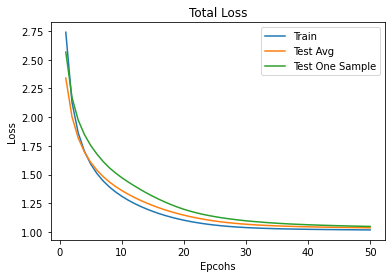

In [13]:
x = torch.arange(1, (NumberOfEpochs+1), dtype=torch.int32)

# Plot the signals on the same graph
plt.plot(x, train_loss_train, label='Train')
plt.plot(x, test_avg_loss_train, label='Test Avg')
plt.plot(x, test_loss_train, label='Test One Sample')

# Set labels and title
plt.xlabel('Epcohs')
plt.ylabel('Loss')
plt.title('Total Loss')

# Add legend
plt.legend()

# Display the plot
plt.show()


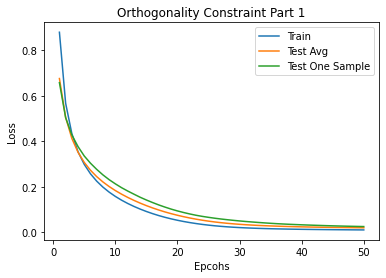

In [14]:

# Plot the signals on the same graph
plt.plot(x, train_obj1_train, label='Train')
plt.plot(x, test_avg_obj1_train, label='Test Avg')
plt.plot(x, test_obj1_train, label='Test One Sample')

# Set labels and title
plt.xlabel('Epcohs')
plt.ylabel('Loss')
plt.title('Orthogonality Constraint Part 1')

# Add legend
plt.legend()

# Display the plot
plt.show()


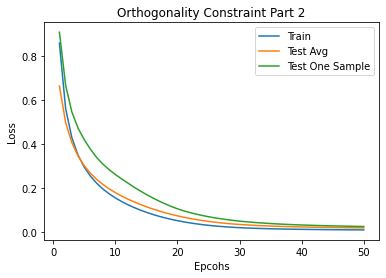

In [15]:
# Plot the signals on the same graph
plt.plot(x, train_obj2_train, label='Train')
plt.plot(x, test_avg_obj2_train, label='Test Avg')
plt.plot(x, test_obj2_train, label='Test One Sample')

# Set labels and title
plt.xlabel('Epcohs')
plt.ylabel('Loss')
plt.title('Orthogonality Constraint Part 2')

# Add legend
plt.legend()

# Display the plot
plt.show()


In [16]:
tmp = test_kernel_2d[0:2, :, :]
print(tmp.shape)

torch.Size([2, 20, 20])


In [18]:
model.eval()
with torch.no_grad():
    for i in range(1):
            j = i +1 
            nnOut = model(test_kernel_split[i:j,:])
            print(nnOut)
            testlossPer1 , testobj1Per1, testobj2Per1 = custom_loss(nnOut, test_kernel_2d[i:j, :, :], 1)
           # print(nnOut)

tensor([[ 6.3518e-02, -3.3749e-02, -1.5723e-02, -4.2689e-02, -3.1109e-02,
          6.1113e-03, -4.9345e-02, -1.5807e-02,  3.3108e-02, -3.2311e-03,
          1.3269e-02, -7.9972e-03,  1.8789e-03, -7.2631e-03,  1.2999e-02,
          9.9072e-04, -2.9102e-03, -6.6919e-03,  9.4321e-03,  2.8852e-03,
         -7.5636e-03, -2.2210e-02,  9.5732e-04,  9.7558e-03, -4.3151e-03,
          7.2267e-03, -5.5398e-03,  3.8861e-03, -3.2359e-03,  1.4379e-02,
         -2.7509e-03,  7.1667e-03,  5.6284e-03, -2.7706e-03, -2.8560e-03,
          6.8529e-03, -3.7852e-03,  3.2316e-03, -7.1985e-04,  2.0072e-03,
         -1.0228e-02,  8.3188e-04,  2.7162e-03,  4.2509e-03,  7.5075e-03,
          2.0241e-02,  9.1926e-03, -1.7543e-03, -7.3328e-03, -4.7623e-03,
         -1.3359e-02, -6.5012e-03, -1.0101e-02, -3.0011e-03,  7.7588e-03,
          2.4541e-03, -7.7431e-03, -2.7431e-03,  2.3453e-02, -1.8270e-02,
         -8.2229e-04, -5.7794e-03,  4.3783e-03,  2.3218e-03,  5.9374e-03,
         -6.5385e-03,  3.2392e-04,  7.

In [50]:
            nnOut = model(test_kernel_split[0:128,:])
            testlossPer1 , testobj1Per1, testobj2Per1 = custom_loss(nnOut, test_kernel_2d[0:128, :, :], 128)
            print(testlossPer1)

tensor(1.0954, grad_fn=<AddBackward0>)
